##### Importing the Necessary Libraries

In [1]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import StratifiedKFold,GridSearchCV 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier      
from sklearn.ensemble import GradientBoostingClassifier                     

##### Importing the training dataset

In [2]:
path= r'C:\Users\HP\Desktop\backorder project\artifacts\train.csv'         # Use the path of your saved dataset for avoiding errors
train_data= pd.read_csv(path)
train_data.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,39.0,8.0,0.0,0.0,0.0,10.0,2.0,8.0,16.0,24.0,...,0.0,0.40,0.60,0.0,No,No,No,Yes,No,No
1,26.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,8.0,...,0.0,0.97,0.95,0.0,No,No,No,Yes,No,No
2,1.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
3,308.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.98,0.95,0.0,No,No,No,Yes,No,No
4,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.97,0.98,0.0,No,No,No,Yes,No,No


##### Importing the test dataset

In [3]:
path= r'C:\Users\HP\Desktop\backorder project\artifacts\test.csv'             # Use the path of your saved dataset for avoiding errors
test_data= pd.read_csv(path)
test_data.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,153.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.91,0.90,0.0,No,No,No,Yes,No,No
1,1.0,8.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.79,0.66,0.0,No,No,No,Yes,No,No
2,0.0,2.0,0.0,5.0,8.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.89,0.88,0.0,Yes,No,No,Yes,No,No
3,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.44,0.48,0.0,Yes,No,No,Yes,No,No
4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.70,0.66,0.0,Yes,No,Yes,Yes,No,No


##### Feature Engineering on the Train Dataset

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer

train_data= train_data.drop(['forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)    #Avoiding Multicollinearity

num_cols= [0,1,2,3,4,5,7,8,9]               #The index number of each column is required for transformations
cat_cols= [6,10,11,12,13,14,15]

# To handle missing values and transform data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('power_transform', PowerTransformer())
        ]), num_cols),

        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='if_binary'))
        ]), cat_cols)
    ],
    remainder='passthrough' 
)                                                         

train_data= preprocessor.fit_transform(train_data)
train_data= pd.DataFrame(train_data)

X= train_data.drop([15],axis=1)                            
y= train_data[15]

skf= StratifiedKFold(random_state=42,shuffle=True)                  #Stratified KFold cross val splits for hyperparamter tuning and for getting mean train scores
scaler= StandardScaler()

##### Feature Engineering on the Test Dataset

In [5]:
# Performing the same steps done for train data

test_data= test_data.drop(['forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)                                                          

test_data= preprocessor.transform(test_data)
test_data= pd.DataFrame(test_data)

X_test= test_data.drop([15],axis=1)                            
y_test= test_data[15]

##### GridSearchCV for Logistic Model with Undersampling

In [6]:
#Using PR_AUC as the scoring metric during GridSearchCV

import warnings
warnings.filterwarnings('ignore')                                                       #Training 5min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2','elasticnet'],
    'classifier__solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__l1_ratio':[0,1,0.5]
}

grid_lr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_lr.fit(X,y)
log_model= grid_lr.best_estimator_

best_index= grid_lr.best_index_
results = pd.DataFrame(grid_lr.cv_results_)

print("Best PR AUC Score:", grid_lr.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's Roc score             
print("Best Parameters:", grid_lr.best_params_)

Best PR AUC Score: 0.0777746476143923
Best ROC AUC Score: 0.8930765588551349
Best Parameters: {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}


In [7]:
#Using ROC_AUC as the scoring metric during GridSearchCV

import warnings
warnings.filterwarnings('ignore')                                                           # Train time 5min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2','elasticnet'],
    'classifier__solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__l1_ratio':[0,1,0.5]
}

grid_lr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_lr.fit(X,y)
log_model= grid_lr.best_estimator_

best_index= grid_lr.best_index_
results = pd.DataFrame(grid_lr.cv_results_)

print("Best ROC AUC Score:", grid_lr.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_lr.best_params_)

Best ROC AUC Score: 0.8930765588551349
Best PR AUC Score: 0.0777746476143923
Best Parameters: {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}


Both gave the same results!!!  

So the final parameters for logistic model along with smote would be {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2','classifier__solver': 'newton-cholesky'} 

The performance on test data for Logistic Model with undersampling are as follows:-

Logistic Test ROC Score:  0.865893727834149
Logistic Test PR Score:  0.04184129235080165
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83    383192
         1.0       0.02      0.89      0.04      2796

    accuracy                           0.71    385988
   macro avg       0.51      0.80      0.44    385988
weighted avg       0.99      0.71      0.83    385988



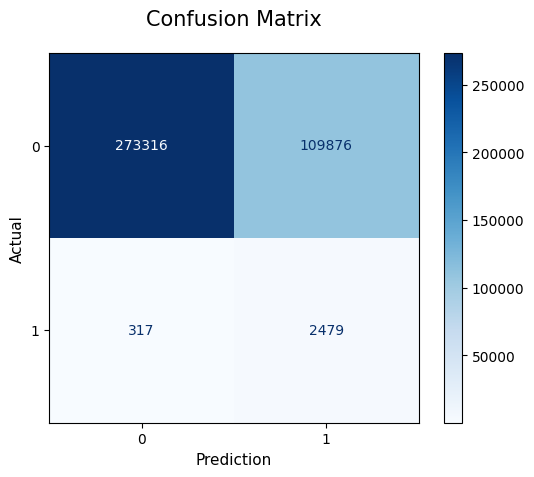

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= log_model.predict_proba(X_test_scaled)[:, 1]
y_predict= log_model.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Logistic Test ROC Score: ',roc_auc)
print('Logistic Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### LinearSVC

In [9]:
from sklearn.svm import LinearSVC               # Training time 20s

svm_model = LinearSVC(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    X_train_scaled= scaler.fit_transform(X_train)
    X_val_scaled= scaler.transform(X_val)

    svm_model.fit(X_train_scaled,y_train)
    y_pred= svm_model.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8562169267043096
PR_score: 0.06472425515969397


SVC Test ROC Score:  0.8631361814690789
SVC Test PR Score:  0.06617937040060923
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.00      0.00      0.00      2796

    accuracy                           0.99    385988
   macro avg       0.50      0.50      0.50    385988
weighted avg       0.99      0.99      0.99    385988



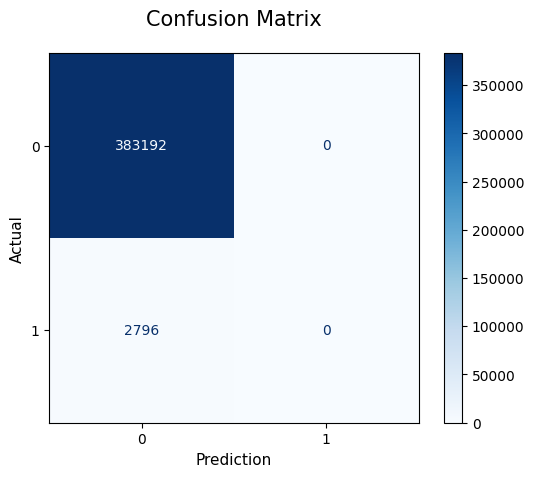

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model.decision_function(X_test_scaled)
y_predict= svm_model.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC Test ROC Score: ',roc_auc)
print('SVC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Linear SVC with Smote

In [11]:
from sklearn.svm import LinearSVC               # Training time 40s

svm_model_sm = LinearSVC(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote= SMOTE(random_state=42)
    X_train_sm, y_train_sm= smote.fit_resample(X_train,y_train)

    X_train_scaled= scaler.fit_transform(X_train_sm)
    X_val_scaled= scaler.transform(X_val)

    svm_model_sm.fit(X_train_scaled,y_train_sm)
    y_pred= svm_model_sm.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8630908433639227
PR_score: 0.06137668043832654


SVC with Smote Test ROC Score:  0.8650406833334124
SVC with Smote Test PR Score:  0.06160011061579754
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.78    383192
         1.0       0.02      0.90      0.04      2796

    accuracy                           0.65    385988
   macro avg       0.51      0.77      0.41    385988
weighted avg       0.99      0.65      0.78    385988



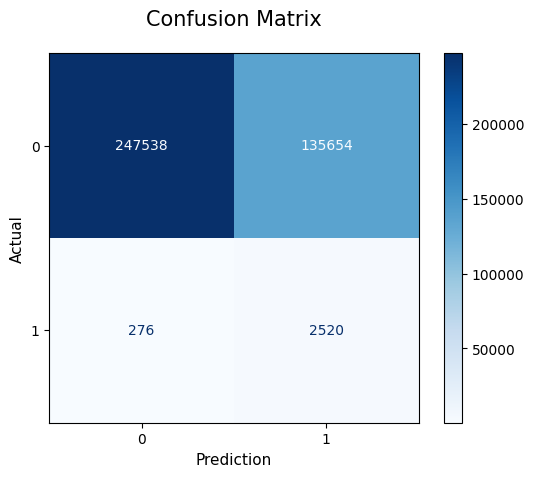

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_sm.decision_function(X_test_scaled)
y_predict= svm_model_sm.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Smote Test ROC Score: ',roc_auc)
print('SVC with Smote Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Linear SVC with RandomOverSampling

In [13]:
svm_model_ovr = LinearSVC(random_state=42)              #Training time 32s
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ovr= RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr= ovr.fit_resample(X_train,y_train)

    X_train_scaled= scaler.fit_transform(X_train_ovr)
    X_val_scaled= scaler.transform(X_val)

    svm_model_ovr.fit(X_train_scaled,y_train_ovr)
    y_pred= svm_model_ovr.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8630531482741844
PR_score: 0.06148846293125256


SVC with Oversampling Test ROC Score:  0.8647946698825418
SVC with Oversampling Test PR Score:  0.06158746654065169
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78    383192
         1.0       0.02      0.90      0.04      2796

    accuracy                           0.65    385988
   macro avg       0.51      0.77      0.41    385988
weighted avg       0.99      0.65      0.78    385988



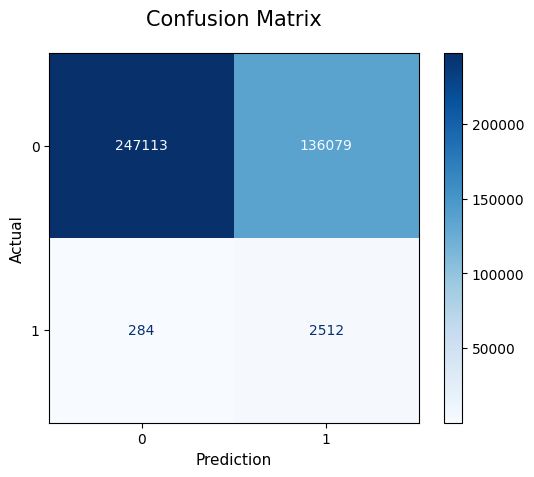

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_ovr.decision_function(X_test_scaled)
y_predict= svm_model_ovr.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Oversampling Test ROC Score: ',roc_auc)
print('SVC with Oversampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Linear SVC with RandomUnderSampling

In [15]:
svm_model_und = LinearSVC(random_state=42)              # Training time 5s
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    und= RandomUnderSampler(random_state=42)
    X_train_und, y_train_und= und.fit_resample(X_train,y_train)

    X_train_scaled= scaler.fit_transform(X_train_und)
    X_val_scaled= scaler.transform(X_val)

    svm_model_und.fit(X_train_scaled,y_train_und)
    y_pred= svm_model_und.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.876176951215545
PR_score: 0.06649118262982232


SVC with Undersampling Test ROC Score:  0.8689957345646917
SVC with Undersampling Test PR Score:  0.061418727849699234
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.78    383192
         1.0       0.02      0.91      0.04      2796

    accuracy                           0.65    385988
   macro avg       0.51      0.78      0.41    385988
weighted avg       0.99      0.65      0.78    385988



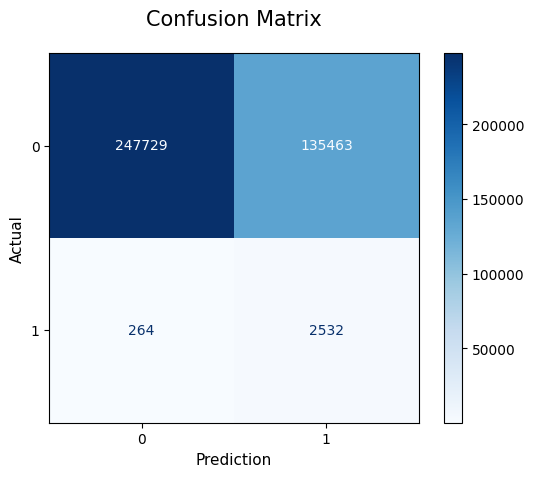

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_und.decision_function(X_test_scaled)
y_predict= svm_model_und.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Undersampling Test ROC Score: ',roc_auc)
print('SVC with Undersampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Since all the sampling techniques resulted in similar but better scores and classification results than normal svc, thus let's perform hyperparameter tuning on Linear SVC with Undersampling.

##### GridSearchCV for LinearSVC with RUS

In [17]:
# Using ROC_AUC for hyperparameter tuning in GridSearchCV

from sklearn.svm import LinearSVC                 

import warnings
warnings.filterwarnings('ignore')

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__loss':['squared_hinge', 'hinge']
}

grid_svm_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_svm_und.fit(X,y)
svm_model_und= grid_svm_und.best_estimator_

best_index= grid_svm_und.best_index_
results = pd.DataFrame(grid_svm_und.cv_results_)

print("Best ROC AUC Score:", grid_svm_und.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_svm_und.best_params_)

Best ROC AUC Score: 0.8923158012927865
Best PR AUC Score: 0.07857290311024197
Best Parameters: {'classifier__C': 10, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


SVC with Undersampling Test ROC Score:  0.8748852833249123
SVC with Undersampling Test PR Score:  0.057389935829882825
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90    383192
         1.0       0.03      0.82      0.06      2796

    accuracy                           0.81    385988
   macro avg       0.51      0.81      0.48    385988
weighted avg       0.99      0.81      0.89    385988



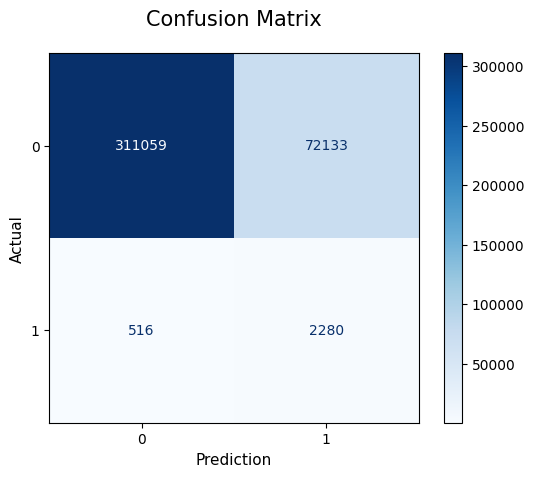

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_und.decision_function(X_test_scaled)
y_predict= svm_model_und.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Undersampling Test ROC Score: ',roc_auc)
print('SVC with Undersampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [19]:
# Using PR_AUC for hyperparameter tuning in GridSearchCV

from sklearn.svm import LinearSVC                 

import warnings
warnings.filterwarnings('ignore')

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__loss':['squared_hinge', 'hinge']
}

grid_svm_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_svm_und.fit(X,y)
svm_model_und= grid_svm_und.best_estimator_

best_index= grid_svm_und.best_index_
results = pd.DataFrame(grid_svm_und.cv_results_)

print("Best PR AUC Score:", grid_svm_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_svm_und.best_params_)

Best PR AUC Score: 0.07866303128829799
Best ROC AUC Score: 0.8915220191879033
Best Parameters: {'classifier__C': 1, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


SVC with Undersampling Test ROC Score:  0.8753673821400125
SVC with Undersampling Test PR Score:  0.05766040450814519
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89    383192
         1.0       0.03      0.82      0.06      2796

    accuracy                           0.81    385988
   macro avg       0.51      0.81      0.48    385988
weighted avg       0.99      0.81      0.89    385988



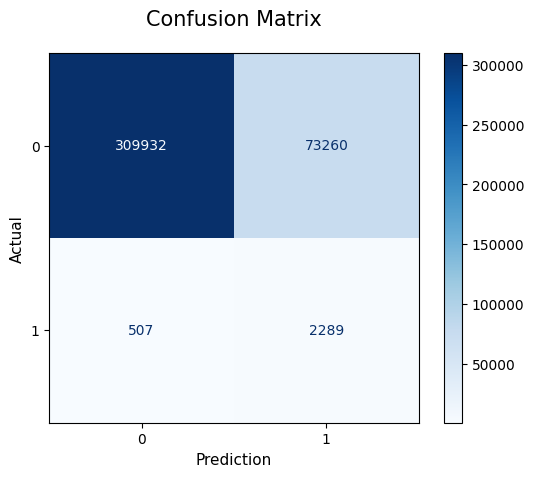

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_und.decision_function(X_test_scaled)
y_predict= svm_model_und.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Undersampling Test ROC Score: ',roc_auc)
print('SVC with Undersampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

As observed both methods resulted in similar scores overall!!

##### GridSearchCV for Decision Tree 

In [21]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 13min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_dt.fit(X,y)
dt_model= grid_dt.best_estimator_

best_index= grid_dt.best_index_
results = pd.DataFrame(grid_dt.cv_results_)

print("Best ROC AUC Score:", grid_dt.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_dt.best_params_)

Best ROC AUC Score: 0.9261299374013445
Best PR AUC Score: 0.14971913686962252
Best Parameters: {'cart__criterion': 'entropy', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


In [22]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 13min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_dt.fit(X,y)
dt_model= grid_dt.best_estimator_

best_index= grid_dt.best_index_
results = pd.DataFrame(grid_dt.cv_results_)

print("Best PR AUC Score:", grid_dt.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_dt.best_params_)

Best PR AUC Score: 0.17645403880165014
Best ROC AUC Score: 0.912939770746096
Best Parameters: {'cart__criterion': 'gini', 'cart__max_depth': 10, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


From the above results, the decision tree model with scoring metric as roc performed better but it focuses completely on negative(0) class and neglects positive(1) class so considering tree model with scoring metric as pr as it considers the positive class too. This statement can be verified by looking at the confusion matrix for both conditions, one with pr and one with roc as scoring metric.

So the final parameters for CART model are :- {'cart__criterion': 'gini', 'cart__max_depth': 15, 'cart__max_features': 10, 'cart__min_samples_leaf': 1}

The test performance of cart model are as follows:-

CART Test ROC Score:  0.911643905578354
CART Test PR Score:  0.13545900437310898
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.28      0.04      0.06      2796

    accuracy                           0.99    385988
   macro avg       0.64      0.52      0.53    385988
weighted avg       0.99      0.99      0.99    385988



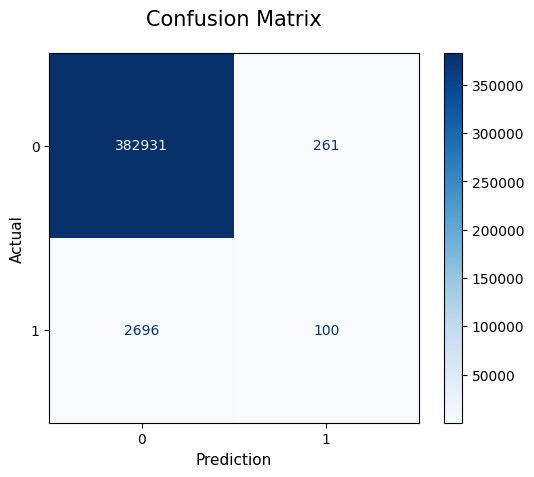

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= dt_model.predict_proba(X_test_scaled)[:, 1]
y_predict= dt_model.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('CART Test ROC Score: ',roc_auc)
print('CART Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Decision Tree with RUS

In [24]:
dt_model_rus= DecisionTreeClassifier(random_state=42)        

roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    dt_model_rus.fit(X_train_und,y_train_und)
    y_pred= dt_model_rus.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')
print(f'PR_scorelist: {pr_score}')

Roc_score: 0.8462656183820867
PR_score: 0.4325569116333983
PR_scorelist: [np.float64(0.438393409075548), np.float64(0.43241068644832537), np.float64(0.4331764483052628), np.float64(0.4258195500248962), np.float64(0.4329844643129592)]


CART RUS Test ROC Score:  0.8501067601121292
CART RUS Test PR Score:  0.435401171214469
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91    383192
         1.0       0.04      0.85      0.07      2796

    accuracy                           0.84    385988
   macro avg       0.52      0.84      0.49    385988
weighted avg       0.99      0.84      0.91    385988



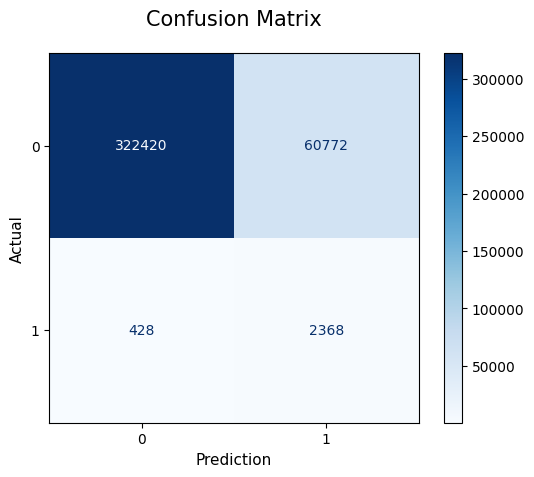

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= dt_model_rus.predict_proba(X_test)[:, 1]
y_predict= dt_model_rus.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('CART RUS Test ROC Score: ',roc_auc)
print('CART RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Decision Tree with RUS

In [26]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 3min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt_rus= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_dt_rus.fit(X,y)
dt_model_rus= grid_dt_rus.best_estimator_

best_index= grid_dt_rus.best_index_
results = pd.DataFrame(grid_dt_rus.cv_results_)

print("Best ROC AUC Score:", grid_dt_rus.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_dt_rus.best_params_)

Best ROC AUC Score: 0.9247399211063435
Best PR AUC Score: 0.10742805552940263
Best Parameters: {'cart__criterion': 'entropy', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


In [27]:
# Using PR_AUC as the scoring metric during GridSearchCV            
# Training time 3min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt_rus= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_dt_rus.fit(X,y)
dt_model_rus= grid_dt_rus.best_estimator_

best_index= grid_dt_rus.best_index_
results = pd.DataFrame(grid_dt_rus.cv_results_)

print("Best PR AUC Score:", grid_dt_rus.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_dt_rus.best_params_)

Best PR AUC Score: 0.10843256844808302
Best ROC AUC Score: 0.9228629123892309
Best Parameters: {'cart__criterion': 'gini', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


Both showed similar results!! 

So the final parameters for Decision Tree with RUS are:- {'cart__criterion': 'gini', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}

The test performance for the CART model with RUS are as follows:-

CART RUS Test ROC Score:  0.9257262837321234
CART RUS Test PR Score:  0.10431794978347911
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.85      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.86      0.51    385988
weighted avg       0.99      0.87      0.92    385988



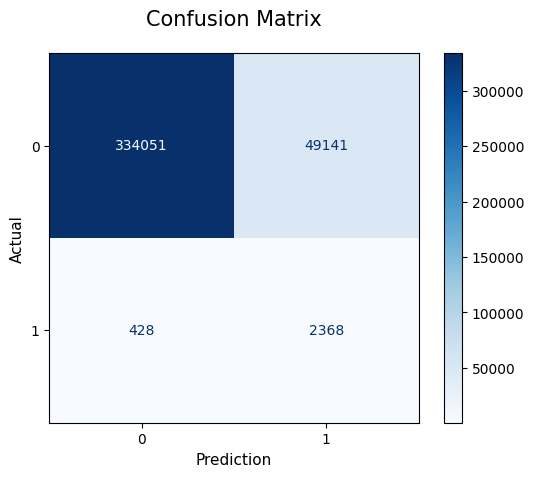

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= dt_model_rus.predict_proba(X_test)[:, 1]
y_predict= dt_model_rus.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('CART RUS Test ROC Score: ',roc_auc)
print('CART RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Random Forest

In [29]:
rforest_model = RandomForestClassifier(random_state=42)         # Training time 15min    
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    rforest_model.fit(X_train,y_train)
    y_pred= rforest_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')
print(f'PR_score: {pr_score}')

Roc_score: 0.8986907315937371
PR_score: 0.31957932631818076
PR_score: [np.float64(0.32548509247858354), np.float64(0.3214944609833785), np.float64(0.3139384072866196), np.float64(0.30990040445932493), np.float64(0.3270782663829972)]


Random Forest Test ROC Score:  0.9028451161586697
Random Forest Test PR Score:  0.30150519353186045
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.58      0.17      0.26      2796

    accuracy                           0.99    385988
   macro avg       0.78      0.58      0.63    385988
weighted avg       0.99      0.99      0.99    385988



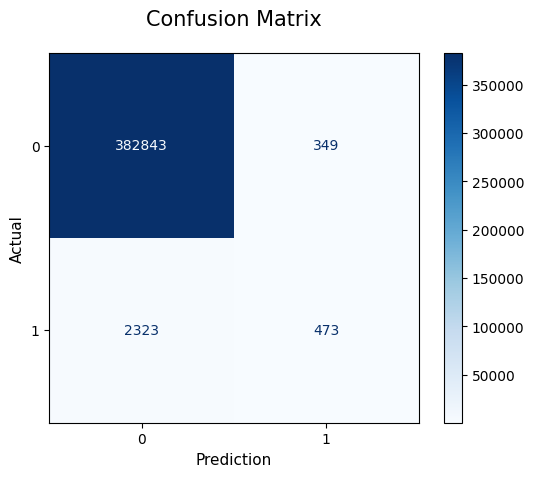

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rforest_model.predict_proba(X_test)[:, 1]
y_predict= rforest_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest Test ROC Score: ',roc_auc)
print('Random Forest Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Random Forest 

In [31]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 8min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_rf.fit(X,y)
rf_model= grid_rf.best_estimator_

best_index= grid_rf.best_index_
results = pd.DataFrame(grid_rf.cv_results_)

print("Best ROC AUC Score:", grid_rf.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_rf.best_params_)

Best ROC AUC Score: 0.9443061968352815
Best PR AUC Score: 0.24828975088310754
Best Parameters: {'forest__criterion': 'entropy', 'forest__max_depth': 20}


Random Forest Test ROC Score:  0.9478107762538074
Random Forest Test PR Score:  0.24883807463708868
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.72      0.01      0.03      2796

    accuracy                           0.99    385988
   macro avg       0.86      0.51      0.51    385988
weighted avg       0.99      0.99      0.99    385988



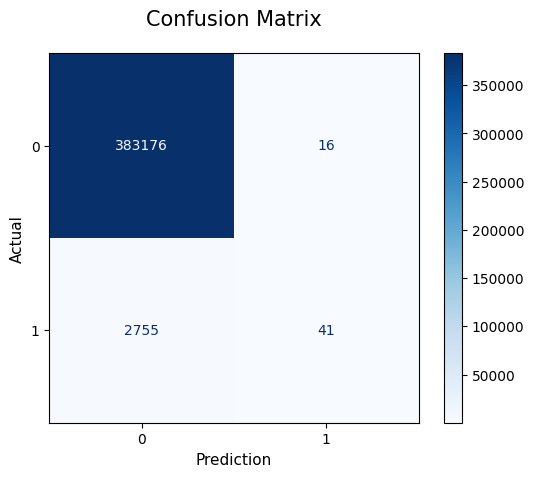

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model.predict_proba(X_test)[:, 1]
y_predict= rf_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest Test ROC Score: ',roc_auc)
print('Random Forest Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

A similar score was obtained for pr metric too

##### GridSearchCV for Random Forest with Smote

model performed slightly better for roc as scoring metric 

In [33]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 24min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('smote',SMOTE(random_state=42)),
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf_sm= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_rf_sm.fit(X,y)
rf_model_sm= grid_rf_sm.best_estimator_

best_index= grid_rf_sm.best_index_
results = pd.DataFrame(grid_rf_sm.cv_results_)

print("Best ROC AUC Score:", grid_rf_sm.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_rf_sm.best_params_)

Best ROC AUC Score: 0.9379273135148818
Best PR AUC Score: 0.19064623693187963
Best Parameters: {'forest__criterion': 'entropy', 'forest__max_depth': 20}


Random Forest with Smote Test ROC Score:  0.9406170663975502
Random Forest with Smote Test PR Score:  0.18991430391621086
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    383192
         1.0       0.09      0.75      0.16      2796

    accuracy                           0.94    385988
   macro avg       0.54      0.85      0.56    385988
weighted avg       0.99      0.94      0.96    385988



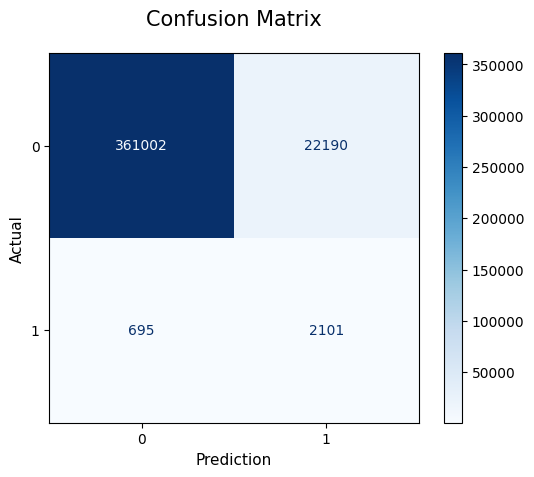

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model_sm.predict_proba(X_test)[:, 1]
y_predict= rf_model_sm.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest with Smote Test ROC Score: ',roc_auc)
print('Random Forest with Smote Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Random Forest with RUS

In [35]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 41s

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_rf_und.fit(X,y)
rf_model_und= grid_rf_und.best_estimator_

best_index= grid_rf_und.best_index_
results = pd.DataFrame(grid_rf_und.cv_results_)

print("Best ROC AUC Score:", grid_rf_und.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_rf_und.best_params_)

Best ROC AUC Score: 0.9386341339841842
Best PR AUC Score: 0.14786626195939068
Best Parameters: {'forest__criterion': 'gini', 'forest__max_depth': 20}


Random Forest with RUS Test ROC Score:  0.9392748893258679
Random Forest with RUS Test PR Score:  0.15371427710898983
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.87      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.87      0.51    385988
weighted avg       0.99      0.87      0.92    385988



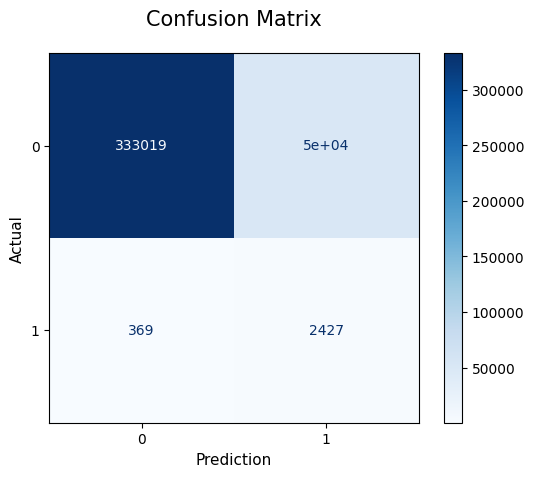

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model_und.predict_proba(X_test)[:, 1]
y_predict= rf_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest with RUS Test ROC Score: ',roc_auc)
print('Random Forest with RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [37]:
# Using PR_AUC as the scoring metric during GridSearchCV            
# Training time 41s

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_rf_und.fit(X,y)
rf_model_und= grid_rf_und.best_estimator_

best_index= grid_rf_und.best_index_
results = pd.DataFrame(grid_rf_und.cv_results_)

print("Best PR AUC Score:", grid_rf_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_rf_und.best_params_)

Best PR AUC Score: 0.15718754404693816
Best ROC AUC Score: 0.93837313245632
Best Parameters: {'forest__criterion': 'entropy', 'forest__max_depth': 15}


Random Forest with RUS Test ROC Score:  0.9362654549797662
Random Forest with RUS Test PR Score:  0.13092052264258192
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    383192
         1.0       0.04      0.88      0.08      2796

    accuracy                           0.86    385988
   macro avg       0.52      0.87      0.50    385988
weighted avg       0.99      0.86      0.92    385988



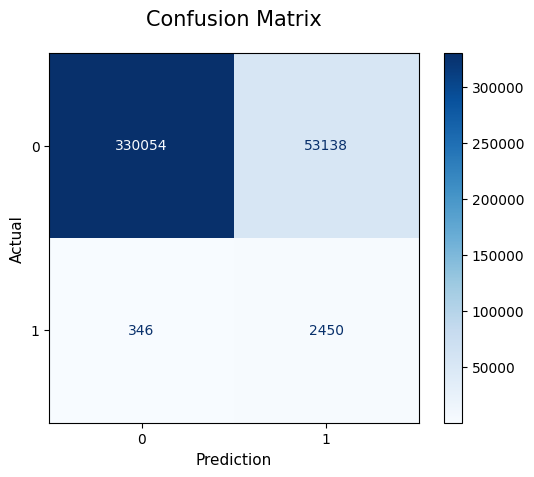

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model_und.predict_proba(X_test)[:, 1]
y_predict= rf_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest with RUS Test ROC Score: ',roc_auc)
print('Random Forest with RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Similar performance shown by both scoring metrics!!

##### GridSearchCV for Gradient Boosting Model

In [39]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 60min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_gb.fit(X,y)
gb_model= grid_gb.best_estimator_

best_index= grid_gb.best_index_
results = pd.DataFrame(grid_gb.cv_results_)

print("Best ROC AUC Score:", grid_gb.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_gb.best_params_)

Best ROC AUC Score: 0.9361129749136378
Best PR AUC Score: 0.18577987524719713
Best Parameters: {'gboost__max_depth': 10}


GBoost Test ROC Score:  0.9398228348665876
GBoost Test PR Score:  0.17962278399820714
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.35      0.10      0.16      2796

    accuracy                           0.99    385988
   macro avg       0.67      0.55      0.58    385988
weighted avg       0.99      0.99      0.99    385988



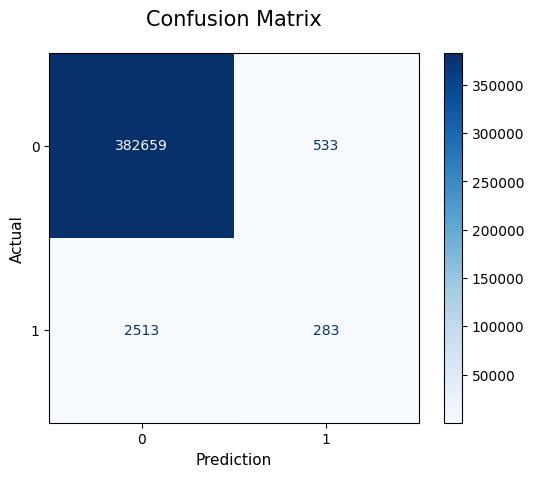

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model.predict_proba(X_test)[:, 1]
y_predict= gb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost Test ROC Score: ',roc_auc)
print('GBoost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [41]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 73min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_gb.fit(X,y)
gb_model= grid_gb.best_estimator_

best_index= grid_gb.best_index_
results = pd.DataFrame(grid_gb.cv_results_)

print("Best PR AUC Score:", grid_gb.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_gb.best_params_)

Best PR AUC Score: 0.19112386402359444
Best ROC AUC Score: 0.7967704125592913
Best Parameters: {'gboost__max_depth': 50}


GBoost Test ROC Score:  0.7917368408881695
GBoost Test PR Score:  0.20463168742004437
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.38      0.27      0.31      2796

    accuracy                           0.99    385988
   macro avg       0.68      0.63      0.65    385988
weighted avg       0.99      0.99      0.99    385988



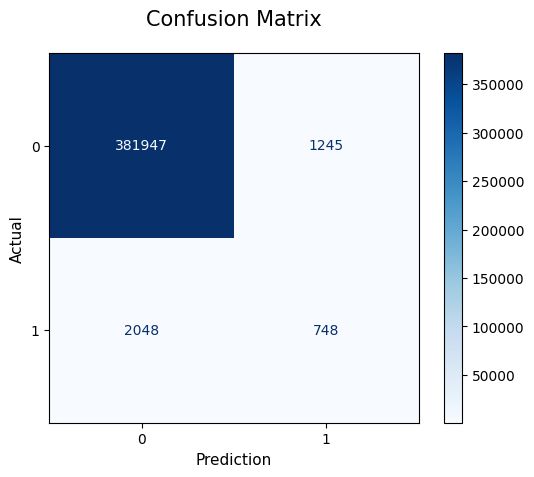

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model.predict_proba(X_test)[:, 1]
y_predict= gb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost Test ROC Score: ',roc_auc)
print('GBoost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Gradient Boosting with roc as scoring metric is showing better performance but pr scoring metric has better slightly recall. 

##### GridSearchCV for Gradient Boost with RUS

In [43]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 1min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('rus',RandomUnderSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_gb_und.fit(X,y)
gb_model_und= grid_gb_und.best_estimator_

best_index= grid_gb_und.best_index_
results = pd.DataFrame(grid_gb_und.cv_results_)

print("Best ROC AUC Score:", grid_gb_und.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_gb_und.best_params_)

Best ROC AUC Score: 0.9378237733639911
Best PR AUC Score: 0.13051027838924253
Best Parameters: {'gboost__max_depth': 10}


GBoost RUS Test ROC Score:  0.9398926450800251
GBoost RUS Test PR Score:  0.1300700729454311
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.88      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.88      0.51    385988
weighted avg       0.99      0.87      0.92    385988



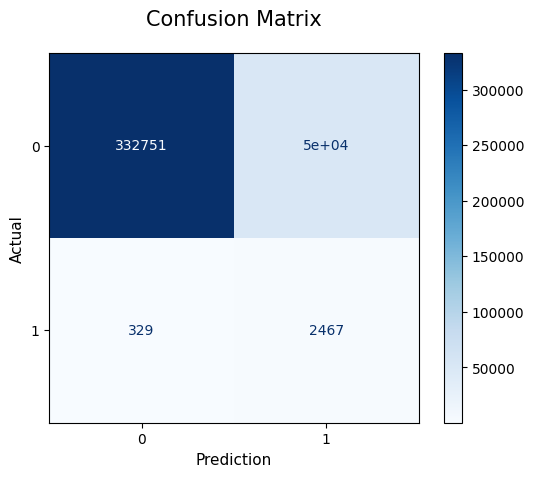

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_und.predict_proba(X_test)[:, 1]
y_predict= gb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost RUS Test ROC Score: ',roc_auc)
print('GBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [45]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 1min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('rus',RandomUnderSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_gb_und.fit(X,y)
gb_model_und= grid_gb_und.best_estimator_

best_index= grid_gb_und.best_index_
results = pd.DataFrame(grid_gb_und.cv_results_)

print("Best PR AUC Score:", grid_gb_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_gb_und.best_params_)

Best PR AUC Score: 0.15636164372897668
Best ROC AUC Score: 0.9362622164887583
Best Parameters: {'gboost__max_depth': 7}


GBoost RUS Test ROC Score:  0.9366647685606108
GBoost RUS Test PR Score:  0.13958916870749788
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.87      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.87      0.51    385988
weighted avg       0.99      0.87      0.92    385988



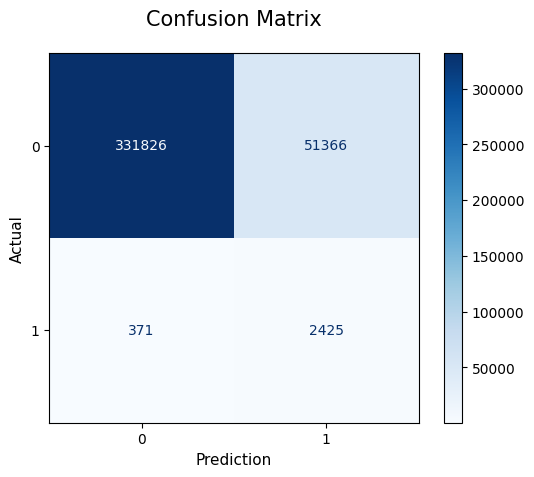

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_und.predict_proba(X_test)[:, 1]
y_predict= gb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost RUS Test ROC Score: ',roc_auc)
print('GBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Similar performance shown by both scoring metric

##### GridSearchCV for Gradient Boost with ROS

In [47]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 96min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('oversamp',RandomOverSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_ovr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_gb_ovr.fit(X,y)
gb_model_ovr= grid_gb_ovr.best_estimator_

best_index= grid_gb_ovr.best_index_
results = pd.DataFrame(grid_gb_ovr.cv_results_)

print("Best PR AUC Score:", grid_gb_ovr.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_gb_ovr.best_params_)

Best PR AUC Score: 0.19350988602464345
Best ROC AUC Score: 0.905909778226466
Best Parameters: {'gboost__max_depth': 15}


GBoost ROS Test ROC Score:  0.9139111923475066
GBoost ROS Test PR Score:  0.20375018195318065
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    383192
         1.0       0.07      0.77      0.13      2796

    accuracy                           0.93    385988
   macro avg       0.54      0.85      0.55    385988
weighted avg       0.99      0.93      0.96    385988



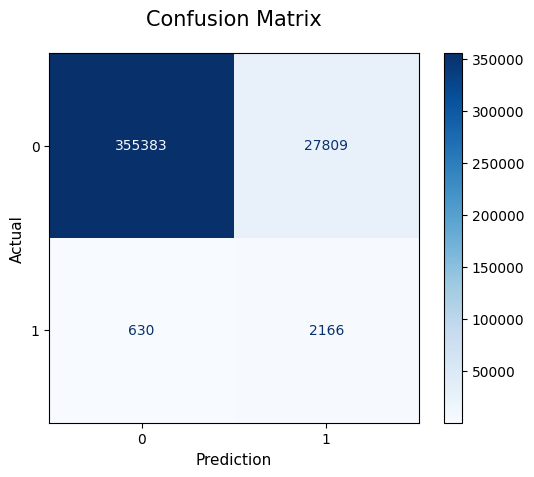

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= gb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost ROS Test ROC Score: ',roc_auc)
print('GBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [49]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 88min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('oversamp',RandomOverSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_ovr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_gb_ovr.fit(X,y)
gb_model_ovr= grid_gb_ovr.best_estimator_

best_index= grid_gb_ovr.best_index_
results = pd.DataFrame(grid_gb_ovr.cv_results_)

print("Best ROC AUC Score:", grid_gb_ovr.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_gb_ovr.best_params_)

Best ROC AUC Score: 0.9378903289087406
Best PR AUC Score: 0.18350017333413032
Best Parameters: {'gboost__max_depth': 10}


GBoost ROS Test ROC Score:  0.9421765497507109
GBoost ROS Test PR Score:  0.17972264714020586
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    383192
         1.0       0.05      0.86      0.10      2796

    accuracy                           0.89    385988
   macro avg       0.53      0.88      0.52    385988
weighted avg       0.99      0.89      0.94    385988



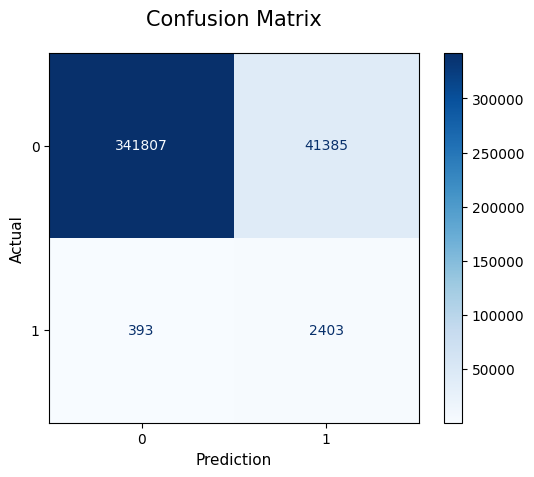

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= gb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost ROS Test ROC Score: ',roc_auc)
print('GBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

ROC Scoring metric performed better than Pr metric!!

##### XGBoost model

In [51]:
import xgboost as xgb                               # Training time 33s

xgb_model = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    xgb_model.fit(X_train,y_train)
    y_pred= xgb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9468005441993128
PR_score: 0.2447465525070407


XGBoost Test ROC Score:  0.946963268875756
XGBoost Test PR Score:  0.23696190087582125
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.61      0.05      0.10      2796

    accuracy                           0.99    385988
   macro avg       0.80      0.53      0.55    385988
weighted avg       0.99      0.99      0.99    385988



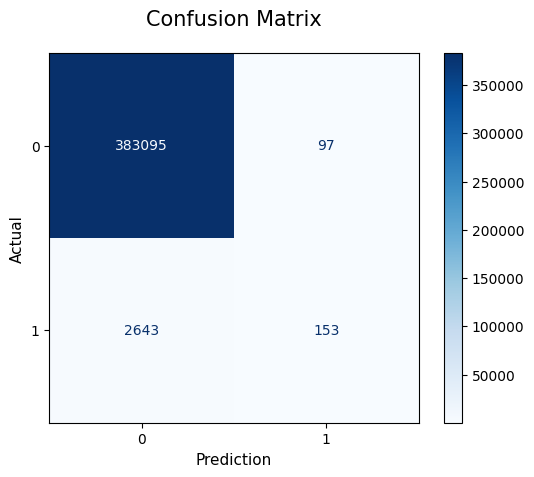

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model.predict_proba(X_test)[:, 1]
y_predict= xgb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost Test ROC Score: ',roc_auc)
print('XGBoost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### XGBoost with Smote

In [53]:
xgb_model_sm = xgb.XGBClassifier(random_state=42)                       # Train time 2min
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    xgb_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= xgb_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9301995665888588
PR_score: 0.1540545764750158


XGBoost Smote Test ROC Score:  0.9300921339320597
XGBoost Smote Test PR Score:  0.15073647768110215
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    383192
         1.0       0.10      0.64      0.18      2796

    accuracy                           0.96    385988
   macro avg       0.55      0.80      0.58    385988
weighted avg       0.99      0.96      0.97    385988



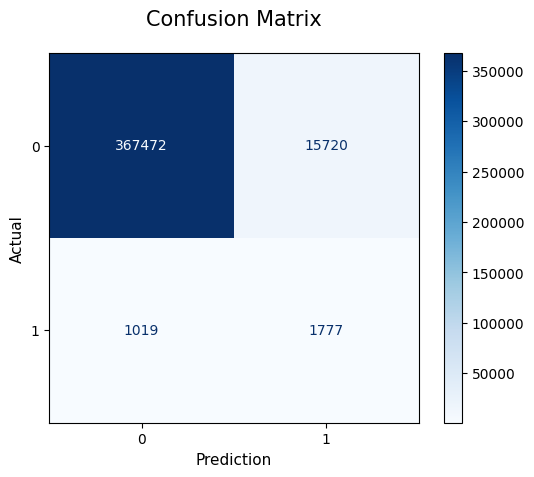

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model_sm.predict_proba(X_test)[:, 1]
y_predict= xgb_model_sm.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost Smote Test ROC Score: ',roc_auc)
print('XGBoost Smote Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### XGBoost with ROS

In [55]:
import xgboost as xgb                               # Training time 1min

xgb_model_ovr = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ovr= RandomOverSampler(random_state=42)
    X_train_ovr,y_train_ovr= ovr.fit_resample(X_train,y_train)

    xgb_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= xgb_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9441761673576942
PR_score: 0.21743591582086097


XGBoost ROS Test ROC Score:  0.9452825087688236
XGBoost ROS Test PR Score:  0.2081491330242708
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    383192
         1.0       0.06      0.86      0.11      2796

    accuracy                           0.90    385988
   macro avg       0.53      0.88      0.53    385988
weighted avg       0.99      0.90      0.94    385988



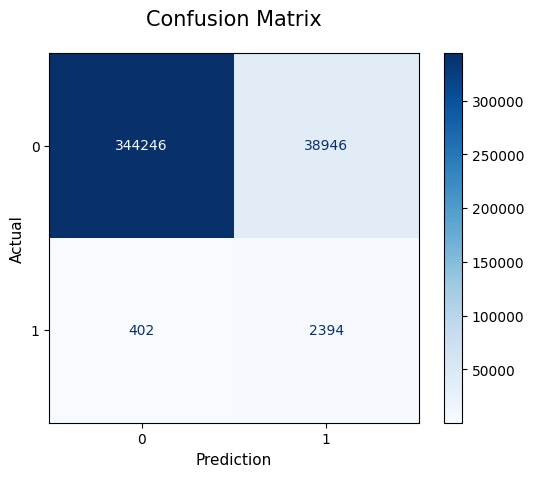

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= xgb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost ROS Test ROC Score: ',roc_auc)
print('XGBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### XGBoost with RUS

In [57]:
xgb_model_und = xgb.XGBClassifier(random_state=42)                  # Train time 4s
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    xgb_model_und.fit(X_train_und,y_train_und)
    y_pred= xgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9436897065756007
PR_score: 0.1609666980872956


XGBoost RUS Test ROC Score:  0.9431749118712208
XGBoost RUS Test PR Score:  0.14939027119445472
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.88      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.88      0.51    385988
weighted avg       0.99      0.87      0.92    385988



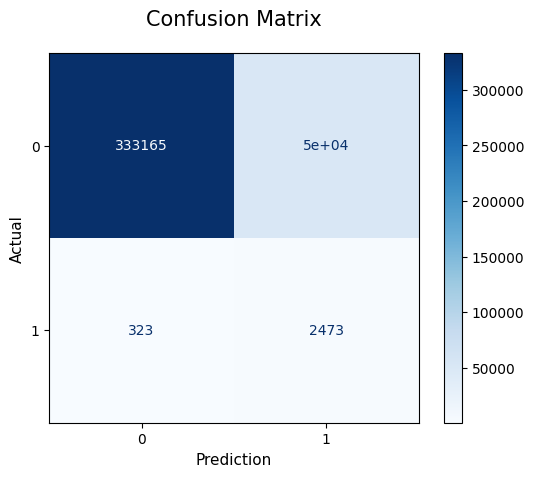

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model_und.predict_proba(X_test)[:, 1]
y_predict= xgb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost RUS Test ROC Score: ',roc_auc)
print('XGBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### LightGBM

In [59]:
import lightgbm as lgb                          # Training time 27s

lgb_model = lgb.LGBMClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    lgb_model.fit(X_train,y_train)
    y_pred= lgb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

[LightGBM] [Info] Number of positive: 8948, number of negative: 1226211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 1235159, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007244 -> initscore=-4.920254
[LightGBM] [Info] Start training from score -4.920254
[LightGBM] [Info] Number of positive: 8948, number of negative: 1226211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 1235159, number of used features: 15
[LightGBM] [

LGBM Test ROC Score:  0.9340188275350245
LGBM Test PR Score:  0.15582067365553412
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    383192
         1.0       0.32      0.08      0.13      2796

    accuracy                           0.99    385988
   macro avg       0.66      0.54      0.56    385988
weighted avg       0.99      0.99      0.99    385988



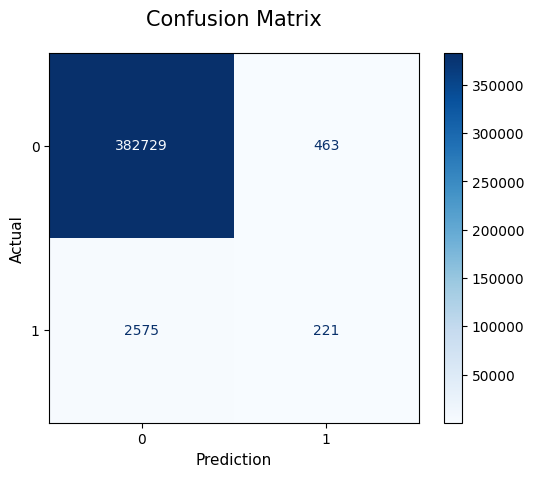

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= lgb_model.predict_proba(X_test)[:, 1]
y_predict= lgb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('LGBM Test ROC Score: ',roc_auc)
print('LGBM Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### LightGBM with RUS

In [61]:
import lightgbm as lgb                          # Training time 7s

lgb_model_und = lgb.LGBMClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    und= RandomUnderSampler(random_state=42)
    X_train_und,y_train_und= und.fit_resample(X_train,y_train)

    lgb_model_und.fit(X_train_und,y_train_und)
    y_pred= lgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

[LightGBM] [Info] Number of positive: 8948, number of negative: 8948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1417
[LightGBM] [Info] Number of data points in the train set: 17896, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8948, number of negative: 8948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 17896, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

LGBM RUS Test ROC Score:  0.9442604767905322
LGBM RUS Test PR Score:  0.1633837886350883
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.89      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.88      0.51    385988
weighted avg       0.99      0.87      0.92    385988



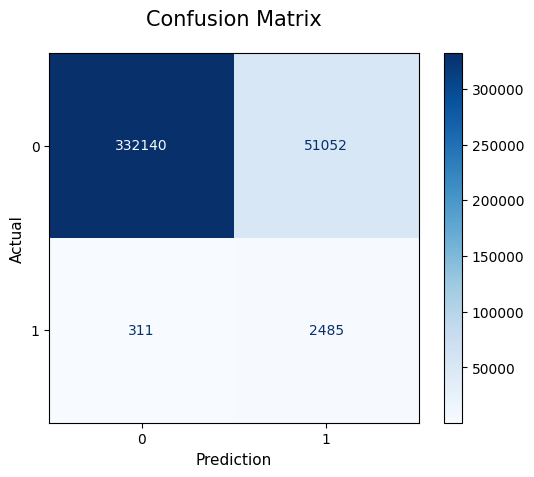

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= lgb_model_und.predict_proba(X_test)[:, 1]
y_predict= lgb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('LGBM RUS Test ROC Score: ',roc_auc)
print('LGBM RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Balanced Bagging

In [63]:
from imblearn.ensemble import BalancedBaggingClassifier                 #Training time 26s

bbc_model = BalancedBaggingClassifier(random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    bbc_model.fit(X_train,y_train)
    y_pred= bbc_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9398021144248275
PR_score: 0.2814864920089418


BBC Test ROC Score:  0.9390272331719333
BBC Test PR Score:  0.27475260650288524
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    383192
         1.0       0.06      0.84      0.11      2796

    accuracy                           0.90    385988
   macro avg       0.53      0.87      0.53    385988
weighted avg       0.99      0.90      0.94    385988



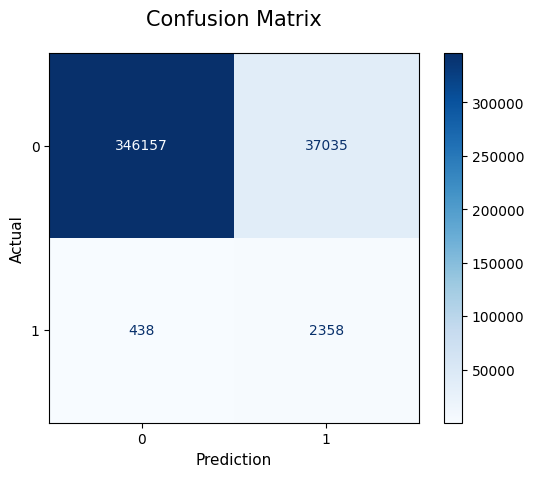

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= bbc_model.predict_proba(X_test)[:, 1]
y_predict= bbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BBC Test ROC Score: ',roc_auc)
print('BBC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Balanced Bagging

In [65]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 20min

from imblearn.ensemble import BalancedBaggingClassifier

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('bbc', BalancedBaggingClassifier(random_state=42))
])

param_grid={
    'bbc__n_estimators':[10,50,100,200,500]
}

grid_bbc= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_bbc.fit(X,y)
bbc_model= grid_bbc.best_estimator_

best_index= grid_bbc.best_index_
results = pd.DataFrame(grid_bbc.cv_results_)

print("Best ROC AUC Score:", grid_bbc.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_bbc.best_params_)

Best ROC AUC Score: 0.9519976610667135
Best PR AUC Score: 0.2521801789025746
Best Parameters: {'bbc__n_estimators': 500}


BBC Test ROC Score:  0.9545994604026576
BBC Test PR Score:  0.24815178961205916
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    383192
         1.0       0.06      0.89      0.11      2796

    accuracy                           0.90    385988
   macro avg       0.53      0.89      0.53    385988
weighted avg       0.99      0.90      0.94    385988



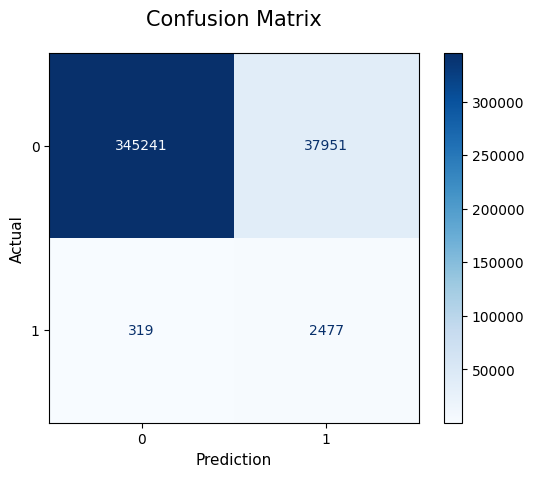

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= bbc_model.predict_proba(X_test)[:, 1]
y_predict= bbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BBC Test ROC Score: ',roc_auc)
print('BBC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [67]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 20min

from imblearn.ensemble import BalancedBaggingClassifier

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('bbc', BalancedBaggingClassifier(random_state=42))
])

param_grid={
    'bbc__n_estimators':[10,50,100,200,500]
}

grid_bbc= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_bbc.fit(X,y)
bbc_model= grid_bbc.best_estimator_

best_index= grid_bbc.best_index_
results = pd.DataFrame(grid_bbc.cv_results_)

print("Best PR AUC Score:", grid_bbc.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_bbc.best_params_)

Best PR AUC Score: 0.2521801789025746
Best ROC AUC Score: 0.9519976610667135
Best Parameters: {'bbc__n_estimators': 500}


BBC Test ROC Score:  0.9545994604026576
BBC Test PR Score:  0.24815178961205916
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    383192
         1.0       0.06      0.89      0.11      2796

    accuracy                           0.90    385988
   macro avg       0.53      0.89      0.53    385988
weighted avg       0.99      0.90      0.94    385988



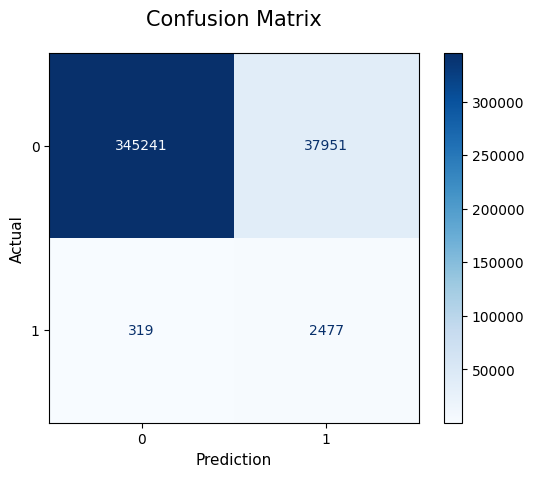

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= bbc_model.predict_proba(X_test)[:, 1]
y_predict= bbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BBC Test ROC Score: ',roc_auc)
print('BBC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Similar performance was shown by both scoring metric!!

##### Balanced Random Forest

In [69]:
from imblearn.ensemble import BalancedRandomForestClassifier                # Training time 4min

brfc_model = BalancedRandomForestClassifier(n_estimators=200,bootstrap=True,replacement=False,sampling_strategy='auto',random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    brfc_model.fit(X_train,y_train)
    y_pred= brfc_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9538843821560083
PR_score: 0.24723154510919443


BRFC Test ROC Score:  0.9526684050833178
BRFC Test PR Score:  0.2330570480096023
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.92      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.89      0.51    385988
weighted avg       0.99      0.87      0.92    385988



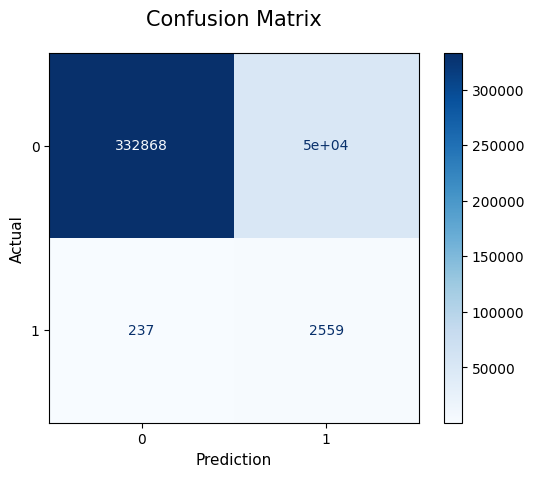

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= brfc_model.predict_proba(X_test)[:, 1]
y_predict= brfc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BRFC Test ROC Score: ',roc_auc)
print('BRFC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### RUS Boosting

In [71]:
from imblearn.ensemble import RUSBoostClassifier                        #Training time 2min

rusbc_model = RUSBoostClassifier(random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    rusbc_model.fit(X_train,y_train)
    y_pred= rusbc_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8708044156590912
PR_score: 0.2179126310263823


RUS Boost Test ROC Score:  0.8730838088100017
RUS Boost Test PR Score:  0.20553586615166394
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    383192
         1.0       0.04      0.74      0.07      2796

    accuracy                           0.86    385988
   macro avg       0.52      0.80      0.50    385988
weighted avg       0.99      0.86      0.92    385988



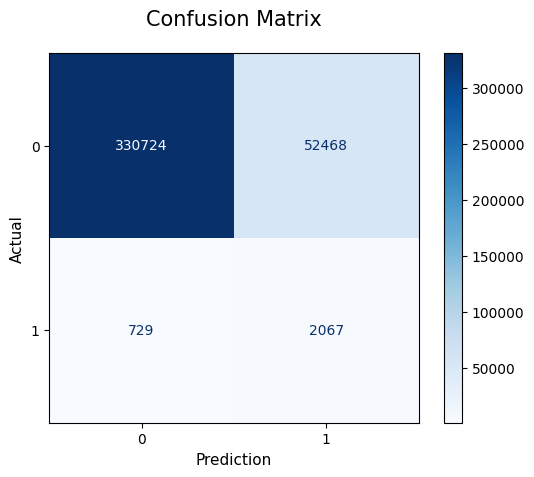

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rusbc_model.predict_proba(X_test)[:, 1]
y_predict= rusbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('RUS Boost Test ROC Score: ',roc_auc)
print('RUS Boost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### EasyEnsemble

In [73]:
from imblearn.ensemble import EasyEnsembleClassifier                        #Training Time 2min

eec_model = EasyEnsembleClassifier(random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    eec_model.fit(X_train,y_train)
    y_pred= eec_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9234469832122748
PR_score: 0.13709068328711754


EasyEnsemble Test ROC Score:  0.9248032759478911
EasyEnsemble Test PR Score:  0.1364012685565147
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    383192
         1.0       0.04      0.85      0.08      2796

    accuracy                           0.86    385988
   macro avg       0.52      0.86      0.50    385988
weighted avg       0.99      0.86      0.92    385988



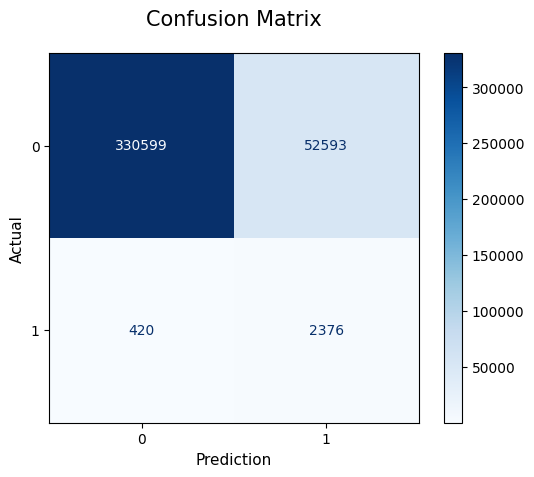

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= eec_model.predict_proba(X_test)[:, 1]
y_predict= eec_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('EasyEnsemble Test ROC Score: ',roc_auc)
print('EasyEnsemble Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))